In [1]:
from scipy import fft
import soundfile as sf
from matplotlib import pyplot as plt
import numpy as np
import librosa
import librosa.display
from matplotlib import cm
import sounddevice as sd

In [2]:
sample_rate = 44100  # samples per second = Hertz = 1/s

duration = 1.0
times = np.linspace(0.0, duration, num=int(duration * sample_rate))

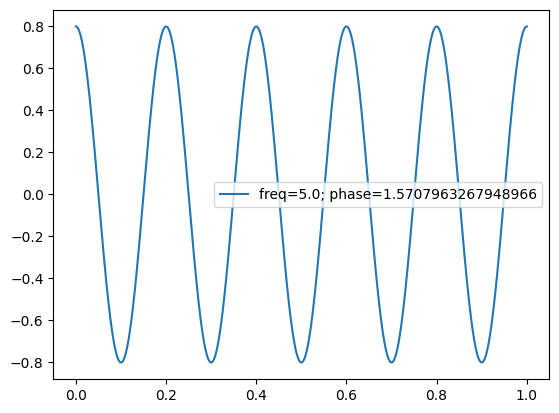

In [4]:
# 01. Sine wave
# =============

amplitude = 0.8
phase = np.pi / 2
freq = 5.0

signal = amplitude * np.sin(freq * (2 * np.pi) * times + phase)
plt.plot(times, signal, label=f"freq={freq}; phase={phase}")
plt.legend()
plt.show()

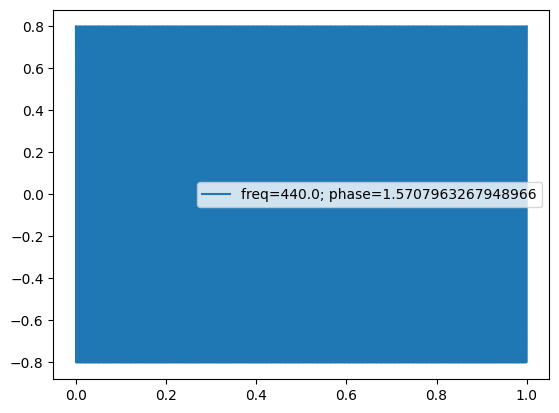

In [27]:
amplitude = 0.8
phase = np.pi / 2
freq = 440.0

signal = amplitude * np.sin(freq * (2 * np.pi) * times + phase)
plt.plot(times, signal, label=f"freq={freq}; phase={phase}")
# increase plot widht to see more details
# plt.xlim(0, 0.01)
plt.legend()
plt.show()

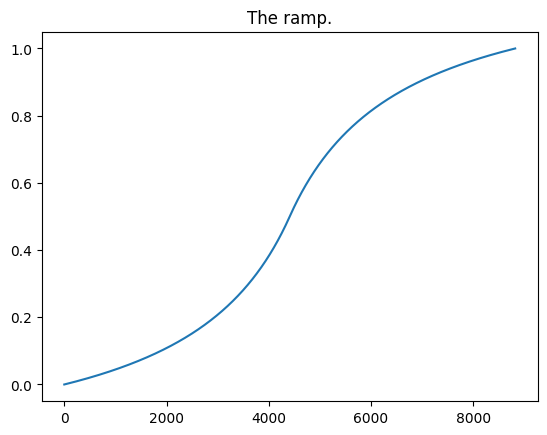

In [31]:
# 20 millisecond ramp

def ntsf(xx, *, kk=0.0):
    """
    Dino Dini's beautiful normalized tunable sigmoid function.

    https://dhemery.github.io/DHE-Modules/technical/sigmoid/

    """
    return (xx - kk * xx) / (kk - 2 * kk * np.abs(xx) + 1)


ramp = 0.5 * (1.0 + ntsf(np.linspace(-1.0, 1.00,
              num=int(0.2 * sample_rate)), kk=-0.5))
              

plt.plot(ramp)
plt.title("The ramp.")
plt.show()

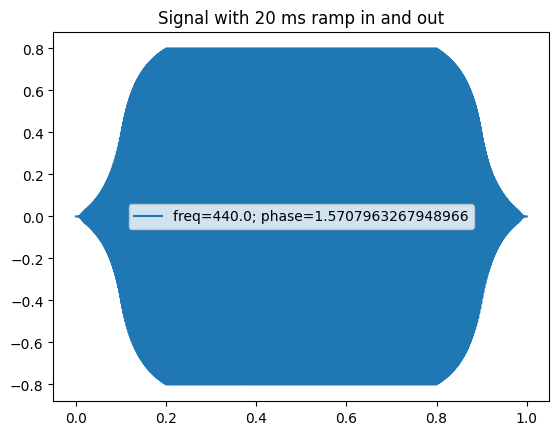

In [32]:
signal[:len(ramp)] *= ramp
signal[-len(ramp):] *= ramp[::-1]

plt.plot(times, signal, label=f"freq={freq}; phase={phase}")
plt.title("Signal with 20 ms ramp in and out")
plt.legend()
plt.show()


def apply_ramp(signal, *, ramp):
    """apply a ramp to a copy of the signal at the start and the end of the
    signal"""
    signal = signal.copy()
    signal[:len(ramp)] *= ramp
    signal[-len(ramp):] *= ramp[::-1]
    return signal


sd.play(signal, samplerate=sample_rate)

In [33]:
# 02. Tones (mixing sine waves)
# =============================

amplitude = 0.8
phase = 0.0
freq = 440.0

a440 = amplitude * np.sin(freq * (2 * np.pi) * times + phase)

freq = 294
d294 = amplitude * np.sin(freq * (2 * np.pi) * times + phase)

freq = 349
f349 = amplitude * np.sin(freq * (2 * np.pi) * times + phase)

freq = 523
c523 = amplitude * np.sin(freq * (2 * np.pi) * times + phase)


signal = apply_ramp(f349, ramp=ramp)
sd.play(signal, samplerate=sample_rate)

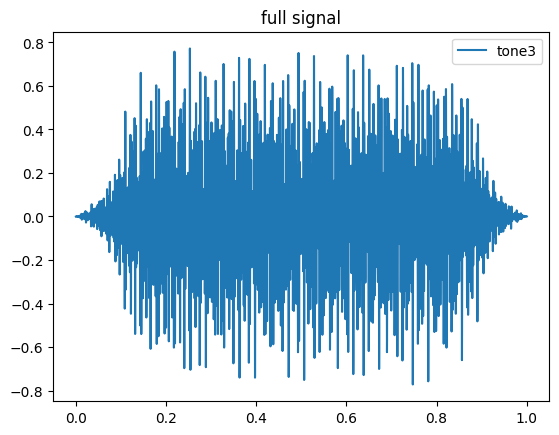

In [37]:
# now start mixing, but we want to keep the maximal amplitude in check.

tone1 = (d294 + a440) / 2

signal = apply_ramp(tone1, ramp=ramp)
sd.play(signal, samplerate=sample_rate)


tone2 = (d294 + a440 + f349) / 3

signal = apply_ramp(tone2, ramp=ramp)
sd.play(signal, samplerate=sample_rate)


tone3 = (d294 + a440 + f349 + c523) / 4

signal = apply_ramp(tone3, ramp=ramp)
sd.play(signal, samplerate=sample_rate)

plt.plot(times, signal, label=f"tone3")
plt.title("full signal")
plt.legend()
plt.show()

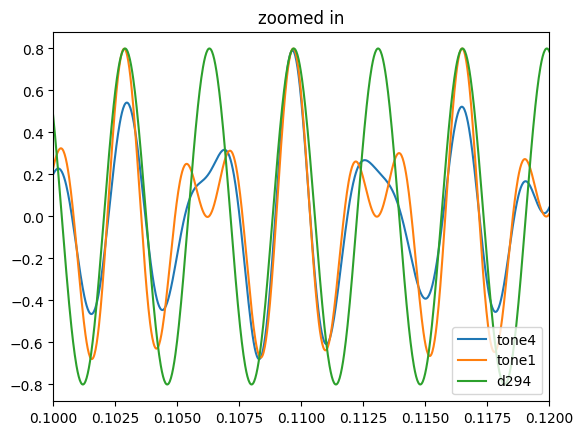

In [38]:
# one last tone with different amplitudes in the source sinus waves
tone4 = 0.5 * d294 + 0.3 * a440 + 0.15 * f349 + 0.05 * c523
signal = apply_ramp(tone3, ramp=ramp)
sd.play(signal, samplerate=sample_rate)

plt.plot(times, tone4, label=f"tone4")
# plt.plot(times, tone3, label=f"tone3")
# plt.plot(times, tone2, label=f"tone2")
plt.plot(times, tone1, label=f"tone1")
plt.plot(times, d294, label=f"d294")
plt.title("zoomed in")
plt.xlim(0.10, 0.12)
plt.legend()
plt.show()

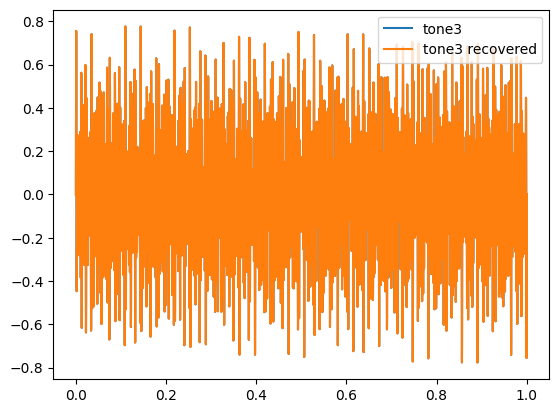

In [39]:
# 03. Decomposing the tone
# ========================


tone3_fft = fft.fft(tone3)
tone3_recov = fft.ifft(tone3_fft)

plt.plot(times, tone3, label="tone3")
plt.plot(times, tone3_recov.real, label="tone3 recovered")
plt.legend()
plt.show()

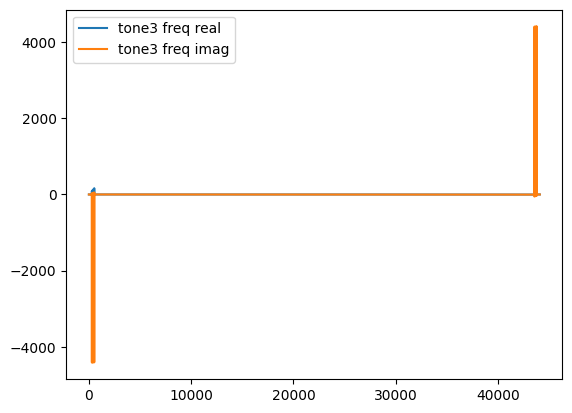

In [12]:
# the orange line is ontop of the blue line

plt.plot(tone3_fft.real, label='tone3 freq real')
plt.plot(tone3_fft.imag, label='tone3 freq imag')
plt.legend()
plt.show()

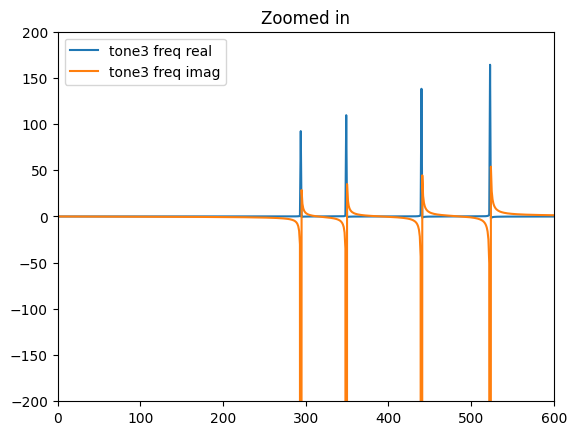

In [40]:
plt.plot(tone3_fft.real, label='tone3 freq real')
plt.plot(tone3_fft.imag, label='tone3 freq imag')
plt.xlim(0, 600)
plt.ylim(-200, 200)
plt.title('Zoomed in')
plt.legend()
plt.show()

In [41]:
# reduce fft values to relevant part
# half of the values are hermitian symmetric / the complex conjugate of the
# first part

tone3_fft_truncated = tone3_fft[:len(tone3_fft)//2]

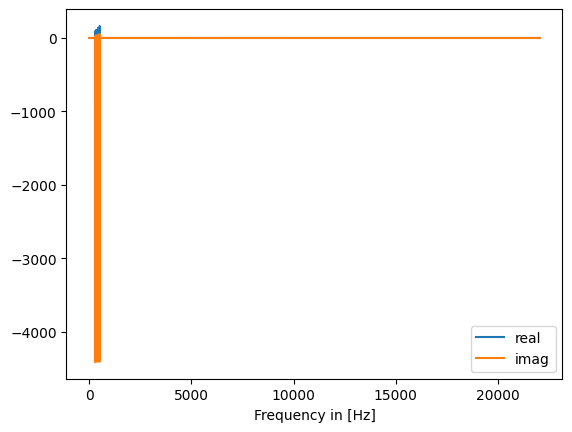

In [42]:
# the frequencies corresponding to each value can be calculated the following
window_length = len(tone3)
freqs = np.arange(len(tone3)//2) * sample_rate / window_length

plt.plot(freqs, tone3_fft_truncated.real, label='real')
plt.plot(freqs, tone3_fft_truncated.imag, label='imag')
plt.xlabel("Frequency in [Hz]")
plt.legend()
plt.show()

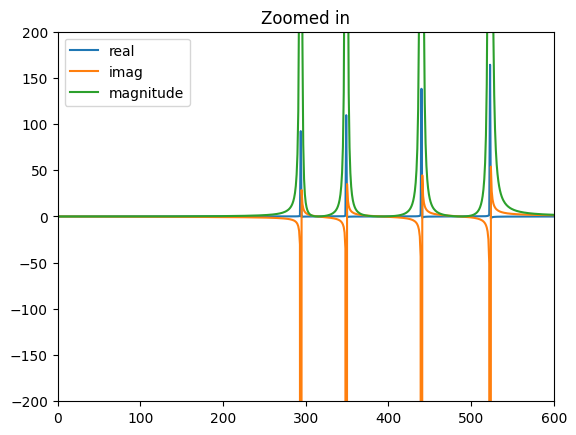

In [16]:
tone3_magnitude = (tone3_fft_truncated * tone3_fft_truncated.conj()).real
plt.plot(tone3_fft.real, label='real')
plt.plot(tone3_fft.imag, label='imag')
plt.plot(tone3_magnitude, label='magnitude')
plt.xlim(0, 600)
plt.ylim(-200, 200)
plt.title('Zoomed in')
plt.legend()
plt.show()

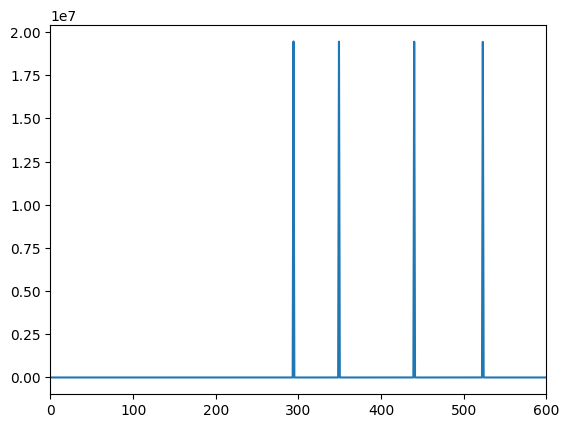

4

In [17]:
# find the peaks in the magnitude


plt.plot(tone3_magnitude, label='magnitude')
plt.xlim(0, 600)
plt.show()

sum(tone3_magnitude > 1.80e7)

In [18]:
# There are four values highter than 18,000,000

np.where(tone3_magnitude > 1.80e7)

# They are at positoins [294, 349, 440, 523]
# and correspond to frequencies:

freqs[np.where(tone3_magnitude > 1.80e7)]

# [294., 349., 440., 523.]

array([294., 349., 440., 523.])

## Assignment part

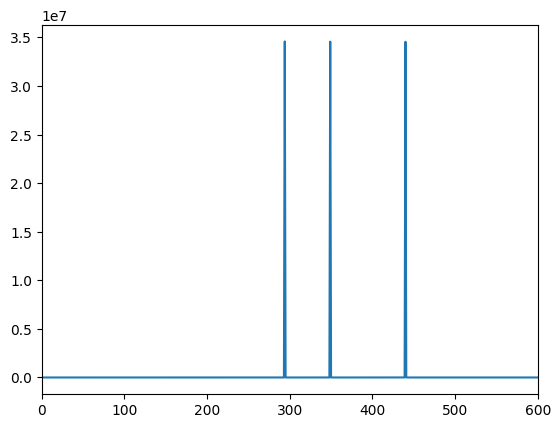

(array([294, 349, 440]),)

In [20]:
# 1. Decompose tone2, what are the frequencies you find?

tone2_fft = fft.fft(tone2)
tone2_fft_truncated = tone2_fft[:len(tone2_fft)//2]
tone2_magnitude = (tone2_fft_truncated * tone2_fft_truncated.conj()).real
plt.plot(tone2_magnitude, label='magnitude')
plt.xlim(0, 600)
plt.show()

np.where(tone2_magnitude > 1.80e7)

# there are three values higher than 1.8e7, at positions [294, 349, 440]
# corresponding to frequencies [294., 349., 440.] Hz

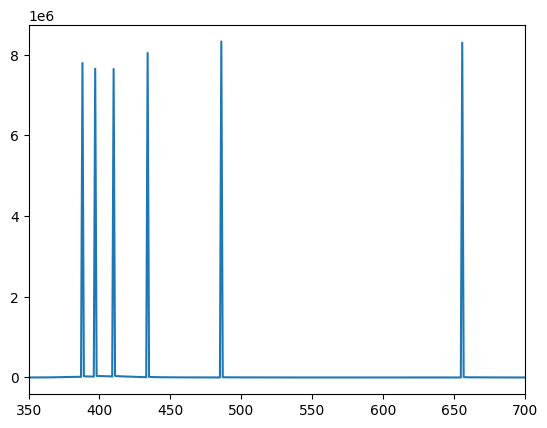

(array([388, 397, 410, 434, 486, 656]),)

In [45]:
# 2. Read in balmer8.flac and decompose the signal. Which are the frequencies used?

balmer8, sample_rate = sf.read("balmer8.flac")
balmer8_fft = fft.fft(balmer8)
balmer8_fft_truncated = balmer8_fft[:len(balmer8_fft)//2]
balmer8_magnitude = (balmer8_fft_truncated * balmer8_fft_truncated.conj()).real
plt.plot(balmer8_magnitude, label='magnitude')
plt.xlim(350, 700)
plt.show()

np.where(balmer8_magnitude > 4e6)

# there are 6 values higher than 4e6, at positions [388, 397, 410, 434, 486, 656]

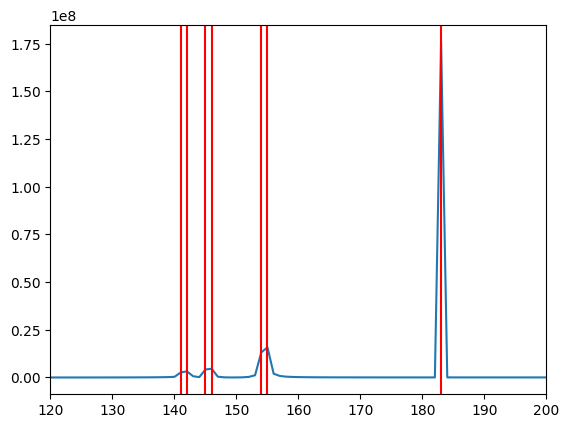

Frequency: 141, Amplitude: 0.014811281218608193
Frequency: 142, Amplitude: 0.018393809843866363
Frequency: 145, Amplitude: 0.02377334258933992
Frequency: 146, Amplitude: 0.025956467634044838
Frequency: 154, Amplitude: 0.07461618850854604
Frequency: 155, Amplitude: 0.08969196397561394
Frequency: 183, Amplitude: 1.0


[None, None, None, None, None, None, None]

In [62]:
# 3. Read in lyman6.flac and decompose the signal. Which are the frequencies
# used? Bonus: With which amplitude are they mixed together?

lyman6, sample_rate = sf.read("lyman6.flac")
lyman6_fft = fft.fft(lyman6)
lyman6_fft_truncated = lyman6_fft[:len(lyman6_fft)//2]
lyman6_magnitude = (lyman6_fft_truncated * lyman6_fft_truncated.conj()).real
plt.plot(lyman6_magnitude, label='magnitude')
# calculate all relevant frequencies and put a vertical line at each of them
# get indices of all values higher than 0.001e8
freqs = np.where(lyman6_magnitude > 0.02e8)[0]
for freq in freqs:
    # color lines red
    plt.axvline(freq, color='r')
    
plt.xlim(120, 200)
plt.show()

amplitudes = lyman6_magnitude[np.where(lyman6_magnitude > 0.02e8)]
# use the largest amplitude as reference, and calculate the other amplitudes as a fraction of it
amplitudes = amplitudes / amplitudes.max()

# it looks to me like there are 7 frequencies used, [141 142 145 146 154 155 183]
# as for the amplitudes, when taking the largest amplitude as reference and expressing the others as a fraction of it, we get:
[print(f"Frequency: {freq}, Amplitude: {amp}") for freq, amp in zip(freqs, amplitudes)]